# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100) 

# Read Data

In [2]:
ch_sample_link = '/data/ch_sample_selections_data.csv'
cg_sample_link = '/data/sample_wsb_gme_personalfin_stock.csv'
rr_sample_link = '/data/forex_finance_finindependence_forex.csv'

file_links = [ch_sample_link, cg_sample_link, rr_sample_link]

In [3]:
ch_sample = pd.read_csv(os.getcwd() + ch_sample_link)
cg_sample = pd.read_csv(os.getcwd() + cg_sample_link)
rr_sample = pd.read_csv(os.getcwd() + rr_sample_link)

In [4]:
print(ch_sample.shape, cg_sample.shape, rr_sample.shape)

(15000, 25) (16000, 25) (6104, 25)


In [5]:
# datatypes match
pd.concat([ch_sample.dtypes,cg_sample.dtypes,rr_sample.dtypes],axis=1)

,0,1,2
Unnamed: 0,int64,int64,int64
id,object,object,object
author,object,object,object
created,object,object,object
retrieved,object,object,object
edited,object,object,object
pinned,int64,int64,int64
archived,int64,int64,int64
locked,int64,int64,int64
removed,int64,int64,int64


In [6]:
def read_files(file_links):
    df = pd.DataFrame()
    for link in file_links:
        df = pd.concat((df, pd.read_csv(os.getcwd() + link)), axis=0)
    return df

In [7]:
df_full = read_files(file_links)

# Split Data for EDA

In [8]:
Y_full = df_full['score']
X_full = df_full.drop(columns='score')

In [9]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['Unnamed: 0', 'id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0])
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [11]:
df = pd.concat((X_train, y_train), axis=1)

In [12]:
df.shape

(25972, 25)

# Examine Training Data

In [13]:
df.shape

(25972, 25)

In [14]:
df.isna().sum()

Unnamed: 0                  0
id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          6312
upvote_ratio                0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    0
thumbnail                   0
shortlink                   0
score                       0
dtype: int64

### Dropping Null selftext values

In [15]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(25972, 25)
(25972, 25)


### Filling NA's for link_flair_text

In [16]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
15284,20126,lh7i6n,fzctungkun,2021-02-10 23:48:12,2021-02-11 11:55:39,1970-01-01 00:00:00,0,0,0,0,...,,0.89,0,0,5,0,\n\nOpendoor Technologies (NASDAQ: OPEN) went public last October and had been quite a hit. I b...,self,https://redd.it/lh7i6n,7
5711,1851,munhjs,[deleted],2021-04-20 10:36:14,2021-04-20 18:21:36,1970-01-01 00:00:00,0,0,0,1,...,,1.00,0,0,0,0,[deleted],default,https://redd.it/munhjs,1


In [17]:
df.describe()

,Unnamed: 0,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
count,25972.000000,25972.0,25972.0,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000
mean,62616.017403,0.0,0.0,0.001309,0.017134,0.014208,0.985792,0.000154,0.003273,0.777999,0.024911,0.734676,66.835438,0.070846,92.938395
std,132684.640865,0.0,0.0,0.036159,0.129773,0.118348,0.118348,0.012409,0.057115,0.198283,0.713756,8.168188,1017.257917,0.560314,1297.568701
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2151.750000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670000,0.000000,0.000000,3.000000,0.000000,1.000000
50%,4353.500000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,8.000000,0.000000,5.000000
75%,62801.500000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.950000,0.000000,0.000000,21.000000,0.000000,18.000000
max,774865.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,108.000000,472.000000,95717.000000,48.000000,138766.000000


Remove the "Unnamed: 0" field

In [18]:
df.iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
4003,4003,lxnzxu,qwaszxxxxxx,2021-03-04 16:06:29,2021-03-05 04:07:39,1970-01-01 00:00:00,0,0,0,0,...,General Discussion,0.95,0,0,31,0,https://www.globenewswire.com/news-release/2021/03/04/2186878/0/en/Kraken-Announces-2-2-Million-...,self,https://redd.it/lxnzxu,85
1119,19235,l0kmix,OhNoWasabiAhead,2021-01-19 14:15:19,2021-02-02 21:55:37,2021-01-19 17:10:45,0,0,0,0,...,DD,0.94,0,1,60,0,TL;DR at the end. These are 2 better safe than sorry fixes for saving your GME tendies.\n\nTwo i...,self,https://redd.it/l0kmix,180


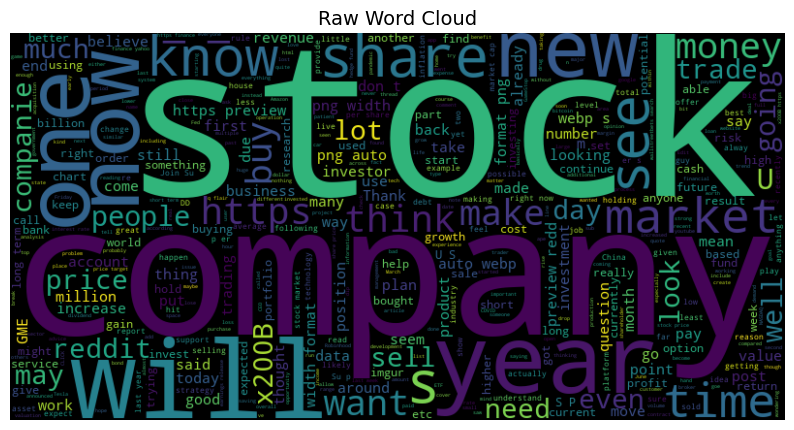

In [19]:
plt.figure(figsize=(10, 10))
words = " ".join(df['selftext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn.

Where are these words coming from?

In [20]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [21]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].iloc[0]

'https://www.globenewswire.com/news-release/2021/03/04/2186878/0/en/Kraken-Announces-2-2-Million-of-Subsea-Batteries-and-Sonar-Contracts-Project-Funding.html'

In [22]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

'<url>'

Remove URL's, and replace with "< url >"

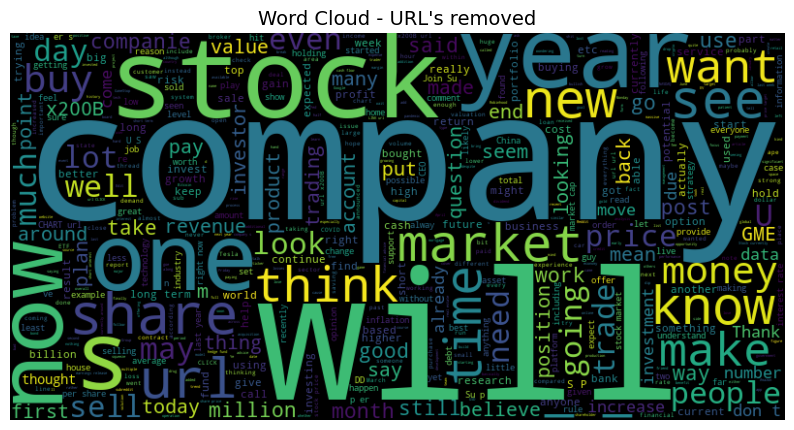

In [23]:
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [24]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['selftext'].iloc[0][:1000]

'Hey everyone,\n\n&#x200B;\n\nI got my first job, and they issued me a pay card from wisely, it came with easy to follow instructions, I activated my card as easy as that. However, all the told me was that it was activated and to visit the mobile app to sign in. They gave me no login info whatsoever, not even in the email they gave me. I tried making a new account by putting in my card info which kept getting errors(my guess is because they asked for only the last 4 digits my ssn on the activation sheet but ask for the full one on the form to connect the card. I am reasonably pissed, Is there some kind of obvious thing that was right in my face? If anyone can help, I appreciate it.'

In [25]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['selftext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

'Hey everyone,\n\n&#;\n\nI got my first job, and they issued me a pay card from wisely, it came with easy to follow instructions, I activated my card as easy as that. However, all the told me was that it was activated and to visit the mobile app to sign in. They gave me no login info whatsoever, not even in the email they gave me. I tried making a new account by putting in my card info which kept getting errors(my guess is because they asked for only the last 4 digits my ssn on the activation sheet but ask for the full one on the form to connect the card. I am reasonably pissed, Is there some kind of obvious thing that was right in my face? If anyone can help, I appreciate it.'

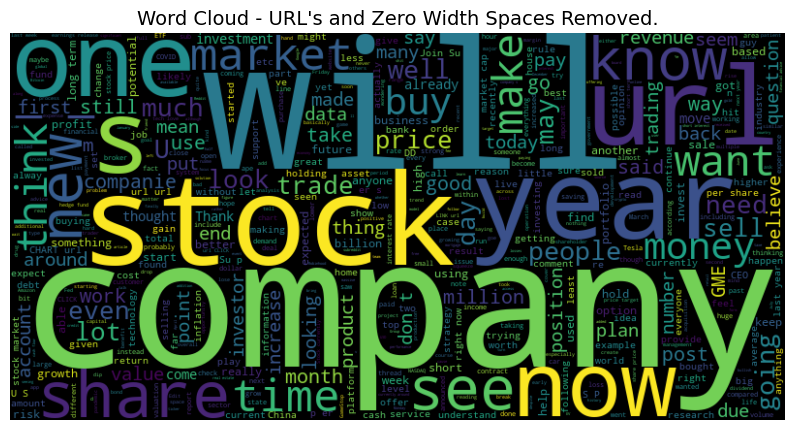

In [26]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [27]:
df['selftext'].value_counts().iloc[:5]

selftext
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [28]:
df.shape, df[df['selftext']!='[deleted]'].shape

((25972, 25), (25603, 25))

### Removing Discussion Posts

In [29]:
text_frequency = df['selftext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['selftext'].tolist()
df[df['selftext'].isin(discussion_posts)].iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
5711,1851,munhjs,[deleted],2021-04-20 10:36:14,2021-04-20 18:21:36,1970-01-01 00:00:00,0,0,0,1,...,NaN,1.00,0,0,0,0,[deleted],default,https://redd.it/munhjs,1
10651,651,ra3ue8,AutoModerator,2021-12-06 10:01:09,2021-12-06 18:03:26,1970-01-01 00:00:00,0,0,0,0,...,NaN,0.83,0,0,24,0,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" ...",self,https://redd.it/ra3ue8,4


# Cleaning Data

### Drop NA's

In [30]:
df = df.dropna(subset='selftext')

### Fill NA's

In [31]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [32]:
df = df[df['selftext']!='[deleted]']

### Remove discussion posts

In [33]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

# df = remove_discussion_posts(df)

### Preprocess data and clean data
We must remove excess HTML and other words.

In [34]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [35]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    text = re.sub('x200B', '', text)
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [36]:
df['selftext'] = df['selftext'].apply(cleaner).apply(preprocessor)

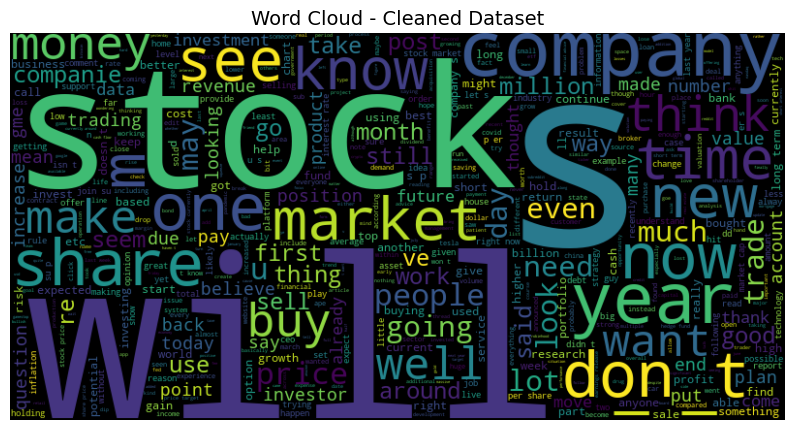

In [37]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

### Examine Numeric Fields

In [38]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
4003,0,0,0,0,0,1,0,0,0.95,0,0,31,0,85
1119,0,0,0,0,0,1,0,0,0.94,0,1,60,0,180
15284,0,0,0,0,0,1,0,0,0.89,0,0,5,0,7
10384,0,0,0,0,0,1,0,0,0.67,0,0,0,0,1
3894,0,0,0,0,0,1,0,0,0.25,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0,0,0,0,0,1,0,0,0.76,1,1,79,0,50
14592,0,0,0,0,0,1,0,0,0.92,0,0,11,0,9
12174,0,0,0,0,0,1,0,0,0.87,0,0,127,0,112
5021,0,0,0,0,0,1,0,0,0.86,0,0,10,0,10


### Scale Numeric Fields

In [39]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [40]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [41]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [42]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
1,l0kmix,OhNoWasabiAhead,2021-01-19 14:15:19,2021-02-02 21:55:37,2021-01-19 17:10:45,0,0,0,0,0,...,DD,tl dr at the end these are 2 better safe than sorry fixes for saving your gme tendies two import...,self,https://redd.it/l0kmix,0.829776,0.065663,-0.035153,0.030971,-0.007587,-0.127301
2,lh7i6n,fzctungkun,2021-02-10 23:48:12,2021-02-11 11:55:39,1970-01-01 00:00:00,0,0,0,0,0,...,,opendoor technologies nasdaq open went public last october and had been quite a hit i bought th...,self,https://redd.it/lh7i6n,0.576752,-0.066720,-0.035153,-0.090592,-0.061271,-0.127301


# Full Dataset Cleaning and Training/Validation/Test Assignments

In [43]:
df_full = df_full.dropna(subset='selftext')

In [44]:
df_full = df_full.fillna({'link_flair_text':''})

In [45]:
df_full = df_full[df_full['selftext']!='[deleted]']

In [46]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

In [47]:
# df = remove_discussion_posts(df)

### Clean and Preprocess Data

In [48]:
df_full['selftext'] = df_full['selftext'].apply(cleaner).apply(preprocessor)

### Drop Columns containing "Unnamed"

In [49]:
df_full = drop_unnamed_columns(df_full)

### Scale Numeric Fields

In [50]:
def scale_numeric_fields(scaler, df, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    df_scaled_values = scaler.fit_transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    
    df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [51]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, scaling_fields)

### Split Data into Train, Validation, Test sets

In [52]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0])
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [53]:
# X_train.to_csv('./data/X_train.csv', index=False)
# y_train.to_csv('./data/y_train.csv', index=False)

# X_val.to_csv('./data/X_val.csv', index=False)
# y_val.to_csv('./data/y_val.csv', index=False)

# X_test.to_csv('./data/X_test.csv', index=False)
# y_test.to_csv('./data/y_test.csv', index=False)